# TP2: Interpolação Polinomial e Regressão Polinomial

Nome: *escreva seu nome aqui*

Matrícula: *escreva sua matrícula aqui*

* Data de entrega: até 23:59 do dia 17/06/2018

* Questões podem ser discutidas entre até três alunos. Nomes dos colegas precisam ser listados. Contudo, a escrita do código e a submissão deve ser feita individualmente.

* Todo material consultado na Internet deve ser referenciado (incluir URL).

* Submissão deve ser feita em formato de ipython notebook (extensão .ipynb) através do Moodle.

Este trabalho está dividido em quatro partes:

* **Parte 0**: Apresentação das implementações vistas em sala
* **Parte 1**: Estudo da estabilidade dos métodos para estimação de quadrados mínimos
* **Parte 2**: Estudo do erro, interpolação vs. regressão
* **Parte 3**: Estudo do tempo de execução, interpolação vs. regressão

## Parte 0: Apresentação das implementações vistas em sala

São listadas a seguir as implementações dos métodos de interpolação vistos em sala.

In [1]:
import numpy as np

def PolinomioNewton(x, y, z):
    m = len(x)
    Delta = np.zeros((m,m))
    Delta[:,0] = y
    for j in range(1,m):
        for i in range(m-j):
            Delta[i,j] = (Delta[i+1,j-1] - Delta[i,j-1])/(x[i+j]-x[i])
    
    # com Processo de Horner
    soma = 0.0
    for j in range(m-1,0,-1):
        soma += Delta[0,j]
        soma *= (z-x[j-1])
    soma += y[0]
        
    return soma

In [2]:
def PolinomioLagrange(x, y, z):
    m = len(x)
    soma = 0
    for i in range(m):
        prod = y[i]
        for j in range(m):
            if j != i:
                prod *= (z-x[j])/(x[i]-x[j])
        soma += prod
        
    return soma

In [3]:
x = 1.0*np.array([3,5,6])
y = 1.0*np.array([-8,-3,4])

print(PolinomioNewton(x,y,4),PolinomioLagrange(x,y,4))

-7.0 -6.999999999999999


Seja a regressão polinomial

$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \ldots + \beta_p x^p + \epsilon.
$$

Os estimadores de mínimos quadrados $\beta$ podem ser obtidos pela solução das equações normais

$$
X^\top X \beta = X^\top y,
$$

onde a matriz $X$ é calculada pela função abaixo.

In [4]:
def RegressaoPolinomial_getX(x,p):
    n = len(x)
    X = np.empty((n,p+1))
    X[:,0] = 1
    X[:,1] = x
    for i in range(2,p+1):
        X[:,i] = X[:,i-1]*x

    return X

In [5]:
RegressaoPolinomial_getX([1.1,1.2,1.7],4)

array([[1.    , 1.1   , 1.21  , 1.331 , 1.4641],
       [1.    , 1.2   , 1.44  , 1.728 , 2.0736],
       [1.    , 1.7   , 2.89  , 4.913 , 8.3521]])

A seguir apresentamos a implementação um gerador de polinômios aleatórios. Mais precisamente, iremos escrever uma função que retorna $p+1$ números aleatórios independentes e com distribuição uniforme entre -5 e 5. Para isto, usamos a função np.random.rand. Tendo em vista que esta função do numpy gera valores em $[0,1)$, iremos transformá-los de maneira a mapeá-los para o intervalo $[-5,5)$.

In [85]:
def geraPolinomioAleatorio(p):
    return -5+10*np.random.rand(p+1)

In [86]:
geraPolinomioAleatorio(3)

array([-2.29699594,  2.79914439,  0.6838937 , -4.2932561 ])

A seguir apresentamos duas funções para gerar tabelas de pontos $(x,y)$ **com erros de medição em $y$**, a partir da avaliação de um polinômio. Vamos assumir que os coeficientes são dados em ordem crescente de grau.

Na primeira função, as abcissas são igualmente espaçadas entre $x_1 = 0$ e $x_n=1$.

Na segunda função, $x_1 = 0$, $x_n = 1$ e o restante das abcissas são escolhidas independentemente de maneira uniforme aleatória no intervalo $[0,1)$.

In [8]:
def geraTabelaAleatoriaY(n, coef):
    x = np.linspace(0,1,n)
    y = np.polyval(coef[::-1],x) + np.random.normal(scale=0.1,size=n)
    return x,y

In [9]:
def geraTabelaAleatoriaXY(n, coef):
    x = np.array([0.0] + list(np.random.rand(n-2)) + [1.0])
    y = np.polyval(coef[::-1],x) + np.random.normal(scale=0.1,size=n)
    return x,y

In [11]:
coef = geraPolinomioAleatorio(3)
x, y = geraTabelaAleatoriaXY(11,coef)
print(x,y)

[0.         0.30007382 0.47895407 0.51852018 0.75038908 0.91744072
 0.17058754 0.2998728  0.68804024 0.08578422 1.        ] [ 0.26022602 -0.15287063 -0.17772332 -0.21295654 -0.59831744 -0.54968166
 -0.02019059 -0.01593865 -0.45772821  0.1162536  -0.93730382]


## Parte 1: Estudo da estabilidade dos métodos para estimação de quadrados mínimos

Nesta parte, vamos comparar os seguintes métodos para a estimação de quadrados mínimos linear:
* SVD
* QR, método de Gram-Schmidt (clássico)
* QR, método de Gram-Schmidt (modificado)
* QR, método de Reflexões de Householder

Para isto, precisamos definir um problema de regressão onde a solução exata (isto é, os coeficientes $\beta$) é conhecida. O código a seguir cria:
* a matriz $X$ a partir de $m=50$ pontos igualmente espaçados entre 0 e 1 usando o método RegressaoPolinomial_getX,
* o vetor $\beta=[1.0,2.0,\ldots,15.0]$, e
* as respostas correspondentes ao vetor $y = X\beta$.

In [13]:
import numpy as np

def createLeastSquaresProblem(m,p):
    x = np.linspace(0.0,1.0,num=m)
    X = RegressaoPolinomial_getX(x,p-1)
    beta = np.arange(1,p+1)
    y = X.dot(beta)
    return X, beta, y

X, beta, y = createLeastSquaresProblem(50,15)

In [14]:
# numero de condicao de X
np.linalg.cond(X)

23271034501.60868

A estimação dos parâmetros $\beta$ usando a decomposição em valores singulares (SVD) já está implementada.

In [51]:
def leastSquares_SVD(X, y):
    m, n = X.shape
    U,s,Vt = np.linalg.svd(X)
    # assumindo m >= n
    a1 = U[:,:n].T @ y
    beta_tilde = a1/s
    beta = Vt.T @ beta_tilde
    return beta

beta_svd = leastSquares_SVD(X,y)
print(beta_svd)

[-0.0166203   0.58128594 -5.15570346 10.06877577 -5.36457357]


**1.1** Complete a implementação do Gram-Schmidt clássico (visto em sala).

In [17]:
def CGS(A):
    m,n = A.shape # numero de colunas
    Q = np.zeros((m,n))
    R = np.zeros((n,n))
    for j in range(n):
        u = A[:,j]
        for i in range(0,j):
            R[i,j] = # tamanho da projecao de aj em qi
            u = u - # subtrai a componente de aj em qi, cujo tamanho eh R[i,j]
        R[j,j] = # tamanho da projecao de u em qj
        Q[:,j] = # u normalizado
    return Q,R

In [18]:
A = 1.0*np.array([[1,1,0],[1,0,1],[0,1,1]])
print(A)
CGS(A)

[[1. 1. 0.]
 [1. 0. 1.]
 [0. 1. 1.]]


(array([[ 0.70710678,  0.40824829, -0.57735027],
        [ 0.70710678, -0.40824829,  0.57735027],
        [ 0.        ,  0.81649658,  0.57735027]]),
 array([[1.41421356, 0.70710678, 0.70710678],
        [0.        , 1.22474487, 0.40824829],
        [0.        , 0.        , 1.15470054]]))

O método Gram-Schmidt modificado é, algebricamente, igual ao método Gram-Schmidt clássico. Contudo, devido a diferenças nos erros de arredondamento, a versão modificada é mais estável numericamente.

O método Gram-Schmidt consiste em:
* criar uma cópia $U$ da matriz $A$
* para cada coluna $i=0,\ldots$:
    * definir $r_{i,i}$ como a norma-2 de $u_i$
    * definir $q_i$ como $u_i$ normalizado
    * para cada coluna $j=i+1,\ldots$:
        - definir $r_{i,j}$ como o tamanho da projeção de $u_j$ em $q_i$
        - subtrair de $u_j$ a projeção de $u_j$ em $q_i$
        
Ou seja, no início da iteração $i$, todas as colunas de $U$ a partir de $i$-ésima são ortogonais a $q_0, q_1, \ldots, q_{i-1}$.

**1.2** Complete a implementação do Gram-Schmidt modificado.

In [19]:
def MGS(A):
    m,n = A.shape # numero de colunas
    U = A.copy()
    Q = np.zeros((m,n))
    R = np.zeros((n,n))
    for i in range(n):
        R[i,i] =
        Q[:,i] =
        for j in range():
            R[i,j] =  # tamanho da projecao de uj em qi
            U[:,j] = U[:,j] -
    return Q,R

In [20]:
MGS(A)

(array([[ 0.70710678,  0.40824829, -0.57735027],
        [ 0.70710678, -0.40824829,  0.57735027],
        [ 0.        ,  0.81649658,  0.57735027]]),
 array([[1.41421356, 0.70710678, 0.70710678],
        [0.        , 1.22474487, 0.40824829],
        [0.        , 0.        , 1.15470054]]))

Os métodos a seguir encontram a solução para o problema de quadrados mínimos linear usando SVD, CGS, MGS e Reflexões de Householder, respectivamente. A solução via SVD já está implementada.

**1.3** Sabendo que CGS, MGS e Reflexões de Householder são métodos de decomposição QR e que, quando $X$ é de posto completo, a solução de

$$
X^\top X \beta = X^\top y
$$

pode ser encontrada resolvendo-se

$$
R\beta = Q^\top y,
$$

complete as três funções abaixo de forma a encontrar as estimativas de quadrados mínimos usando a decomposição QR.

In [27]:
def leastSquares_CGS(X, y):
    Q,R = CGS(X)
    beta = np.linalg.solve(,)
    return beta

beta_cgs = leastSquares_CGS(X,y)
print(beta_cgs)

(50, 15) (15, 15)
[ 8.67778776e-01  2.18872756e+01 -4.80574546e+02  4.59284429e+03
 -2.17276789e+04  5.62887365e+04 -7.93450983e+04  5.03710328e+04
  6.34434682e+03 -2.67797432e+04  1.15165211e+04 -5.74618055e+02
 -7.95429343e+01 -2.11430286e+01 -7.68701597e+00]


In [28]:
def leastSquares_MGS(X, y):
    Q,R = MGS(X)
    beta = np.linalg.solve(,)
    return beta

beta_mgs = leastSquares_MGS(X,y)
print(beta_mgs)

[ 1.00000342e+00  1.99665316e+00  3.21134716e+00 -1.12488686e+00
  7.02691254e+01 -4.96291762e+02  2.52989793e+03 -8.64398386e+03
  2.07813163e+04 -3.52487028e+04  4.21266697e+04 -3.46149193e+04
  1.86662499e+04 -5.91228764e+03  8.56699287e+02]


In [29]:
import scipy.linalg

def leastSquares_Householder(X,y):
    Q,R = scipy.linalg.qr(X, mode='economic')
    beta = np.linalg.solve(,)
    return beta

beta_hh = leastSquares_Householder(X,y)
print(beta_hh)

[ 1.          2.          3.          4.          4.99999998  6.00000017
  6.99999915  8.00000285  8.99999321 10.00001147 10.99998631 12.00001128
 12.9999939  14.00000195 14.99999972]


No caso da estimação de quadrados mínimos via Decomposição QR (qualquer que seja o método), podemos decompor a matriz $X|y$, isto é, a matriz $X$ augumentada por $y$. Seja $X|b = Q R$. Fazendo-se $Qb = R[0:n,n]$ e $R = R[0:n,0:n]$, pode se mostrar que a solução para $R \beta = Q_b$ é a solução das equações normais.

A seguir, utilizamos esta ideia para obter a versão augumentada do método Gram-Schmidt modificado.

In [30]:
def leastSquares_MGSAug(X, y):
    Qb,R = MGS(np.hstack((X,y[:,np.newaxis])))
    beta = np.linalg.solve(R[:-1,:-1],R[:-1,-1])
    return beta

beta_mgsaug = leastSquares_MGSAug(X,y)
print(beta_mgsaug)

[ 1.          2.          3.          4.          5.          5.99999996
  7.0000002   7.9999993   9.00000175  9.99999693 11.00000378 11.99999681
 13.00000176 13.99999943 15.00000008]


**1.4** Para podermos comparar os métodos, vamos escrever uma função que calcula duas medidas de erro. A primeira é a norma do resíduo *normalizada*. Seja um sistema linear $Ax = b$. A norma do resíduo de uma solução $x$ é definida por $\|b - Ax\|_2$. Contudo, este valor não é invariante às normas $\|A\|_2$ e $\|b\|_2$. Por esta razão, a primeira medida de erro, $\rho(x)$ é a razão entre a norma do resíduo e o produto $\|A\|_2\|b\|_2$: 

$$
    \rho(x) = \frac{\|b - Ax\|_2}{\|A\|\|b\|_2}.
$$

A segunda medida de erro é simplesmente:

$$
\textrm{erro} = \|x - x_\textrm{exato}\|_2.,
$$

onde $x_\textrm{exato}$ é a solução exata para $Ax=b$.

In [31]:
def calculaErros(A,b,x,x_exato):
    rho = 
    erro = 
    return rho, erro

rho, erro = calculaErros(X,y,beta_hh,beta)
print(rho,erro)

1.650805403355461e-16 2.328448500264901e-05


A seguir contruímos uma tabela com os resultados de cada um dos métodos para determinar qual deles é melhor.

In [36]:
names = ['CGS','MGS','MSGAug','Householder']
functions = [leastSquares_CGS,leastSquares_MGS,leastSquares_MGSAug,leastSquares_Householder]

name2error = dict()

for i in range(len(names)):
    beta_ = functions[i](X,y)
    name2error[names[i]] = calculaErros(X,y,beta_,beta)
    
name2error

(50, 15) (15, 15)


{'CGS': (5.061734797296098e-07, 115693.86968000102),
 'Householder': (1.650805403355461e-16, 2.328448500264901e-05),
 'MGS': (4.297271331252853e-11, 71502.93641997196),
 'MSGAug': (1.3207705681800357e-16, 5.9848696721262775e-06)}

Veja abaixo o resultado obtido com a implementação existente na biblioteca scipy.optmize. O erro medido através de $\|\beta - \beta_\textrm{exato}\|_2$ é apenas um pouco menor do que aquele obtido com MSGAug:

In [37]:
import scipy.optimize
ret = scipy.optimize.lsq_linear(X,y)
print('Scipy',calculaErros(X,y,ret.x,beta))

Scipy (4.907026365372843e-16, 4.521820132160345e-06)


## Parte 2: Estudo do erro, interpolação vs. regressão

Nesta parte, iremos usar os métodos mais estáveis de Interpolação e de estimação de mínimos quadrados para avaliar o erro de previsão quando há erros de medição. Iremos investigar as seguintes questões:

* O que acontece com o erro de interpolação quando aumentamos o grau do polinômio?
* O que acontece com o erro da regressão polinomial quando aumentamos o número de pontos?
* Dado um polinômio de grau $n$, qual dos métodos retorna as melhores previsões?

**2.1** Antes de mais nada, precisamos definir uma função que fará a escolha de pontos.

**Entrada:** um vetor $x$, uma abscissa $z$ e o número de pontos $n$ a serem escolhidos.

**Saída:** Sejam $i$ e $j$ o menor e o maior índice dos pontos que devem ser usados como pontos-base. A função deve retornar $i$ e $j+1$.

Você pode assumir que as coordenadas de $x$ estão em ordem estritamente crescente e que $x[0] < z < x[-1]$. Usaremos a função numpy.searchsorted.

In [38]:
def escolhePontos(x,z,n):
    right_pos = np.searchsorted(x,z)
    left_pos = right_pos-1
    
    xlen = len(x)
    while (right_pos - left_pos +1) < n:
        if right_pos == :
            left_pos =
            break
        if left_pos == :
            right_pos =
            break
        if :
            right_pos += 1
        else:
            left_pos -= 1
    return left_pos, right_pos+1

print(escolhePontos([0,1,3,5,6],4,3))
print(escolhePontos([0,1,3,5,6],0.5,3))
print(escolhePontos([0,1,3,5,6],1.5,2))
print(escolhePontos([0,1,3,5,6],5.5,4))
print(escolhePontos([0,1,2,3,4,5],1.5,4))

(2, 5)
(0, 3)
(1, 3)
(1, 5)
(0, 4)


**2.2** O que acontece com o erro de interpolação quando aumentamos o grau do polinômio?
Para responder esta pergunta, vamos:
* gerar um polinômio de grau $p=4$
* gerar uma tabela com $n=30$ pontos igualmente espaçados em $[0,1)$ (ver itens 1.3 e 1.4),
* gerar um vetor z_vec contendo $\textrm{ntests}=1000$ abscissas aleatórias dos pontos a serem aproximados,
* para cada grau $t=2,\ldots,p+4$:
    * para cada $z$ em z_vec:
        - usar interpolação polinomial de grau $t$ para aproximar ordenada de $z_j$
        - calcular o erro quadrático da aproximação, i.e. $(y_\textrm{exato}-y_\textrm{aprox})^2$

Text(0,0.5,'erro quadrático médio')

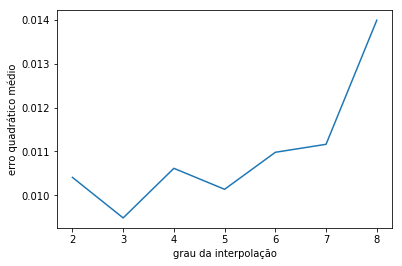

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

p = 4
n = 30
ntests = 1000

# gera coeficientes do polinomio
coef = 

# gera tabela de n pontos
x,y = 

# gera abscissas aleatorias (casos de teste)
z_vec = 
y_exato = np.polyval(coef[::-1],z_vec)

erros = np.zeros(p+3)
for t in range(2,p+5):
    for i in range(ntests):
        z =
        l_ind,r_ind = escolhePontos(x, z, t+1)
        y_aprox = PolinomioNewton(x[:], y[:], z)
        erros[t-2] += 
    erros[t-2] /= ntests

fig = plt.figure()
fig.add_subplot(111)
plt.plot(np.arange(2,p+5),erros)
plt.xlabel('grau da interpolação')
plt.ylabel('erro quadrático médio')

**2.3** O que acontece com o erro da regressão polinomial quando aumentamos o número de pontos dados?

Agora iremos fixar o grau da regressão polinomial $t=2,4, \ldots, p+4$ e aumentar o número de pontos $m=t+1,\ldots,t+20$ usados para estimar os parâmetros.

Os pontos serão escolhidos aleatoriamente dentre aqueles no vetor $x$ gerado na questão anterior. Além disso, é interessante que a estimação feita com $m=t+i$ pontos inclua todos os pontos usados na estimação feita com $m=t+i-1$ pontos. Uma forma de se satisfazer ambos os requisitos isto é embaralhar os vetores $x$ e $y$ e usar sempre os $m$ primeiros elementos.

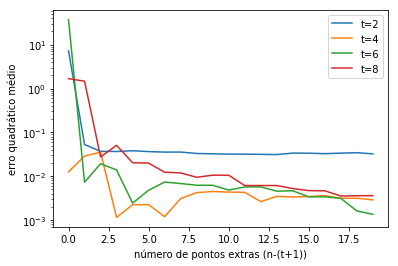

In [132]:


x_shuffled = 
y_shuffled = 

X = RegressaoPolinomial_getX(x_shuffled,p+4)

fig = plt.figure()
fig.add_subplot(111)
for t in range(2,p+5,2):
    erros = np.zeros(20)
    for m in range(t+1,t+21):
        beta = leastSquares_MGSAug(,)
        y_aprox = np.polyval(beta[::-1],z_vec)
        erros[m-(t+1)] = 
        
    # plotar os resultados para grau t
    plt.semilogy(np.arange(0,20),erros,label='t={}'.format(t))
    plt.xlabel('número de pontos extras (n-(t+1))')
    plt.ylabel('erro quadrático médio')
    plt.legend()

**2.4** Dado um polinômio de grau $t=2,\ldots,p+4$, qual dos métodos retorna as melhores previsões?

Para responder esta pergunta, iremos repetir o experimento anterior, adicionando uma reta tracejada correspondente ao erro da interpolação para cada grau.

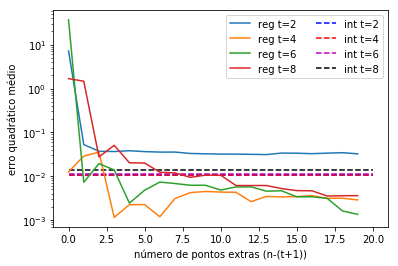

In [136]:
fig = plt.figure()
fig.add_subplot(111)
for t in range(2,p+5,2):
    erros = np.zeros(20)
    for m in range(t+1,t+21):
        beta = leastSquares_MGSAug(,)
        y_aprox = np.polyval(beta[::-1],z_vec)
        erros[m-(t+1)] =

    y_interp = np.zeros(ntests)
    for i in range(ntests):
        z =
        l_ind, r_ind = escolhePontos(x,z,t+1)
        y_interp[i] = PolinomioNewton(x[:],y[:],z)
    erro_interp  = np.average()
          
    # plotar os resultados para grau t
    plt.semilogy(np.arange(0,20),erros,label='reg t={}'.format(t))
    plt.hlines(erro_interp,0,20,colors=colors[t-2],linestyles='--',label='int t={}'.format(t))
    plt.xlabel('número de pontos extras (n-(t+1))')
    plt.ylabel('erro quadrático médio')
    plt.legend(ncol=2)

## Parte 3: Estudo do tempo de execução, interpolação vs. regressão

Vimos em sala que o custo da interpolação polinomial de grau $n$ é $\mathcal{O}(n^2)$ e que o custo para se construir as equações normais de uma regressão polinomial é $\mathcal{O}(np^2) = \mathcal{O}(n^3)$.

Contudo, tanto a interpolação polinomial quanto a regressão polinomial raramente consideram valores grandes de $n$, fazendo com que a diferença no custo computacional seja irrisória caso o método seja executado poucas vezes.

Nesta parte iremos medir o tempo de execução dos dois métodos variando $n$. Mais adiante, iremos considerar também o tempo necessário para se resolver as equações normais por Cholesky como parte integrante da regressão polinomial.

Vamos utilizar o comando mágico %timeit para medir o tempo de execução de cada um dos métodos. Consulte a [documentação do IPython](http://ipython.readthedocs.io/en/stable/interactive/magics.html) para ver o seu funcionamento. *Não confundir com o comando time*.

**3.1** Escolha os parâmetros do comando %timeit de modo a executar 4 vezes um loop com $10^4$ chamadas a PolinomioNewton(x, y, z). No bloco de código seguinte, faça o mesmo para a função constroiEquacoesNormais_v1.

In [143]:
# geracao da funcao y = P(x)

p = 4
coef = geraPolinomioAleatorio(p) 
x, y = geraTabelaAleatoriaY(p+1, coef)

# geracao do ponto a ser interpolado
z = np.random.rand()
  
%timeit PolinomioNewton(x, y, z)

23.7 µs ± 2.18 µs per loop (mean ± std. dev. of 4 runs, 1000 loops each)


In [142]:
def constroiEquacoesNormais_v1(x,y,p):
    n = len(x)
    p = p+1
    A = np.zeros((p,p))
    b = np.zeros(p)
    for i in range(p):
        for j in range(p):
            for k in range(n):
                A[i,j] += x[k]**(i+j)
                
    for i in range(p):
        for k in range(n):
            b[i] += y[k] * x[k]**i
            
    return A,b
            

%timeit constroiEquacoesNormais_v1(x,y,p)

130 µs ± 9.2 µs per loop (mean ± std. dev. of 4 runs, 1000 loops each)


Note que só a construção das equações normais está levando bem mais tempo que a interpolação polinomial. Contudo, veremos que as constantes da complexidade de tempo vão depender da nossa implementação.

**3.2** Usando o fato de que a matriz $A = X^\top X$ é simétrica, altere a implementação anterior reproduzida abaixo para calcular apenas a diagonal e elementos superiores de $A$. Em seguida, some $A$ e sua transposta $A^\top$, subtraindo também os elementos da diagonal de $A$, tendo em vista que eles foram somados duas vezes. Use a função np.diag.

In [141]:
def constroiEquacoesNormais_v2(x,y,p):
    n = len(x)
    p = p+1
    A = np.zeros((p,p))
    b = np.zeros(p)
    for i in range(p):
        for j in range(p):
            for k in range(n):
                A[i,j] += x[k]**(i+j)
                
    for i in range(p):
        for k in range(n):
            b[i] += y[k] * x[k]**i
            
    return A,b
            

%timeit constroiEquacoesNormais_v2(x,y,p)

97.7 µs ± 6.42 µs per loop (mean ± std. dev. of 4 runs, 1000 loops each)


Esta nova implementação deve ter reduzido um pouco o tempo de execução, mas este ainda deve ser bem maior que o tempo da interpolação polinomial. (Por quê o tempo não foi reduzido pela metade?) Veremos a seguir que o uso de operações algébricas com matrizes podem acelerar consideravelmente uma função.

**3.3** Complete a função abaixo usando a função RegressaoPolinomial_getX para construir a matriz $X$ e, em seguinda, calcular $A = X^\top X$ e $b = X^\top y$ através de operações matriciais. Calcule o tempo de execução. 

In [45]:
def constroiEquacoesNormais_v3(x,y):
    p = 
    X = RegressaoPolinomial_getX(x,p);
    A = 
    b = 
    return A, b

%timeit constroiEquacoesNormais_v3(x,y)

19.6 µs ± 2.18 µs per loop (mean ± std. dev. of 4 runs, 1000 loops each)


**3.4** Agora que você conhece uma forma eficiente de escrever as equações normais, use scipy.linalg.cho_factor e scipy.linalg.cho_solve para encontrar os coeficientes de quadrados mínimos usando Cholesky.

In [49]:
import scipy.linalg

def leastSquares_Cholesky(X, y):
    XtX =
    Xty =
    U, lower =
    beta =
    return beta
    
X = RegressaoPolinomial_getX(x,p)
beta_chol = leastSquares_Cholesky(X,y)
print(beta_chol)

[-0.0166203   0.58128594 -5.15570346 10.06877577 -5.36457357]


A lista seguinte de métodos retorna os coeficientes estimador da regressão linear, dados a matriz $X$ e o vetor $y$:

* leastSquares_Cholesky
* leastSquares_SVD
* leastSquares_Householder

O código abaixo que compara o tempo de execução de cada um dos métodos anteriores.

In [144]:
names = ['EqN_Chol','SVD','Householder']
function_names = [leastSquares_Cholesky,leastSquares_SVD,leastSquares_Householder]

name2time = dict()
for ix,f in enumerate(function_names):
    time = %%timeit -q -o X = RegressaoPolinomial_getX(x,p); f(X,y)
    name2time[names[ix]] = time.average

In [145]:
name2time

{'EqN_Chol': 8.630594195731516e-05,
 'Householder': 0.00012098147330003225,
 'SVD': 5.033531830039075e-05}